In [80]:
from bs4 import BeautifulSoup
import requests
from slugify import slugify
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import numpy as np

import ipywidgets as widgets
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt


In [50]:
BASE_URL = "https://www.sahibinden.com/"

In [51]:
def get_html(url):
    response = requests.get(url, headers={"User-Agent": "Mozilla/5.0","accept": "text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9"})
    return response.content
base_page = get_html("{}{}".format(BASE_URL,"otomobil"))

In [4]:
soup = BeautifulSoup(base_page, "html.parser")

In [53]:
brands = soup.find_all("li", {"class": "cl2"})

In [54]:
def clear_raw_data(data):
    dataList = []
    for tag in data:
        brand = tag.text.strip().split("(")[0].strip() 
        brand = slugify(brand)

        dataList.append(brand)
    return dataList

    

In [55]:
brandList = clear_raw_data(brands)

In [56]:
chosenBrand = widgets.Dropdown(
    options=brandList,
    description='Brand:',
    disabled=False,
)
chosenBrand

Dropdown(description='Brand:', options=('acura', 'aion', 'alfa-romeo', 'anadol', 'aston-martin', 'audi', 'bent…

In [57]:
MODELS_URL = BASE_URL + chosenBrand.value

In [58]:
modelsPage = get_html(MODELS_URL)

In [59]:
models = BeautifulSoup(modelsPage, "html.parser")
models = models.find_all("li", {"class": "cl3"})
models = clear_raw_data(models)
models = np.unique(models)

In [60]:
chosenModel = widgets.Dropdown(
    options=models,
    description='Number:',
    disabled=False,
)
chosenModel

/Users/berkkan/opt/anaconda3/lib/python3.9/site-packages/traitlets/traitlets.py:588: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  silent = bool(old_value == new_value)


Dropdown(description='Number:', options=('citigo', 'fabia', 'favorit', 'felicia', 'forman', 'octavia', 'rapid'…

In [61]:
def clean_sahibinden_table(table):
    usefulContentDF = table.dropna(axis=0, how="all")
    usefulContentDF = usefulContentDF[["Yıl", "KM", "Fiyat","Model"]]
    usefulContentDF['KM'] = (usefulContentDF['KM']*1000).astype(int)
    usefulContentDF['Fiyat'] = usefulContentDF['Fiyat'].str.replace(" TL", "")
    usefulContentDF['Fiyat'] = usefulContentDF['Fiyat'].str.replace(".", "").astype(int)
    return usefulContentDF

In [62]:
df = pd.DataFrame(columns=["Yıl", "KM", "Fiyat","Model"], dtype=int)

In [63]:
for offset in range(0, 1500, 50):
    print(offset)
    QUERY_PARAM = "?pagingOffset={}&pagingSize=50&sorting=date_desc".format(offset)
    QUERY_URL = MODELS_URL + "-" + chosenModel.value + QUERY_PARAM

    content = get_html(QUERY_URL)
    content = BeautifulSoup(content, "html.parser")
    content = content.find("table", {"id": "searchResultsTable"})
    contentDF = pd.read_html(str(content))[0]
    contentDF = clean_sahibinden_table(contentDF)
    df = df.append(contentDF, ignore_index=True)

    
df


0


/var/folders/7k/r54zsyhd639_44dxvy8hkzj40000gn/T/ipykernel_1153/3113079336.py:6: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  usefulContentDF['Fiyat'] = usefulContentDF['Fiyat'].str.replace(".", "").astype(int)
/var/folders/7k/r54zsyhd639_44dxvy8hkzj40000gn/T/ipykernel_1153/1598243538.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(contentDF, ignore_index=True)


50


/var/folders/7k/r54zsyhd639_44dxvy8hkzj40000gn/T/ipykernel_1153/3113079336.py:6: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  usefulContentDF['Fiyat'] = usefulContentDF['Fiyat'].str.replace(".", "").astype(int)
/var/folders/7k/r54zsyhd639_44dxvy8hkzj40000gn/T/ipykernel_1153/1598243538.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(contentDF, ignore_index=True)


100


/var/folders/7k/r54zsyhd639_44dxvy8hkzj40000gn/T/ipykernel_1153/3113079336.py:6: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  usefulContentDF['Fiyat'] = usefulContentDF['Fiyat'].str.replace(".", "").astype(int)
/var/folders/7k/r54zsyhd639_44dxvy8hkzj40000gn/T/ipykernel_1153/1598243538.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(contentDF, ignore_index=True)


150


/var/folders/7k/r54zsyhd639_44dxvy8hkzj40000gn/T/ipykernel_1153/3113079336.py:6: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  usefulContentDF['Fiyat'] = usefulContentDF['Fiyat'].str.replace(".", "").astype(int)
/var/folders/7k/r54zsyhd639_44dxvy8hkzj40000gn/T/ipykernel_1153/1598243538.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(contentDF, ignore_index=True)


200


/var/folders/7k/r54zsyhd639_44dxvy8hkzj40000gn/T/ipykernel_1153/3113079336.py:6: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  usefulContentDF['Fiyat'] = usefulContentDF['Fiyat'].str.replace(".", "").astype(int)
/var/folders/7k/r54zsyhd639_44dxvy8hkzj40000gn/T/ipykernel_1153/1598243538.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(contentDF, ignore_index=True)


250


/var/folders/7k/r54zsyhd639_44dxvy8hkzj40000gn/T/ipykernel_1153/3113079336.py:6: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  usefulContentDF['Fiyat'] = usefulContentDF['Fiyat'].str.replace(".", "").astype(int)
/var/folders/7k/r54zsyhd639_44dxvy8hkzj40000gn/T/ipykernel_1153/1598243538.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(contentDF, ignore_index=True)


300


/var/folders/7k/r54zsyhd639_44dxvy8hkzj40000gn/T/ipykernel_1153/3113079336.py:6: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  usefulContentDF['Fiyat'] = usefulContentDF['Fiyat'].str.replace(".", "").astype(int)
/var/folders/7k/r54zsyhd639_44dxvy8hkzj40000gn/T/ipykernel_1153/1598243538.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(contentDF, ignore_index=True)


350


/var/folders/7k/r54zsyhd639_44dxvy8hkzj40000gn/T/ipykernel_1153/3113079336.py:6: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  usefulContentDF['Fiyat'] = usefulContentDF['Fiyat'].str.replace(".", "").astype(int)
/var/folders/7k/r54zsyhd639_44dxvy8hkzj40000gn/T/ipykernel_1153/1598243538.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(contentDF, ignore_index=True)


400


/var/folders/7k/r54zsyhd639_44dxvy8hkzj40000gn/T/ipykernel_1153/3113079336.py:6: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  usefulContentDF['Fiyat'] = usefulContentDF['Fiyat'].str.replace(".", "").astype(int)
/var/folders/7k/r54zsyhd639_44dxvy8hkzj40000gn/T/ipykernel_1153/1598243538.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(contentDF, ignore_index=True)


450


/var/folders/7k/r54zsyhd639_44dxvy8hkzj40000gn/T/ipykernel_1153/3113079336.py:6: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  usefulContentDF['Fiyat'] = usefulContentDF['Fiyat'].str.replace(".", "").astype(int)
/var/folders/7k/r54zsyhd639_44dxvy8hkzj40000gn/T/ipykernel_1153/1598243538.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(contentDF, ignore_index=True)


500


/var/folders/7k/r54zsyhd639_44dxvy8hkzj40000gn/T/ipykernel_1153/3113079336.py:6: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  usefulContentDF['Fiyat'] = usefulContentDF['Fiyat'].str.replace(".", "").astype(int)
/var/folders/7k/r54zsyhd639_44dxvy8hkzj40000gn/T/ipykernel_1153/1598243538.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(contentDF, ignore_index=True)


550


/var/folders/7k/r54zsyhd639_44dxvy8hkzj40000gn/T/ipykernel_1153/3113079336.py:6: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  usefulContentDF['Fiyat'] = usefulContentDF['Fiyat'].str.replace(".", "").astype(int)
/var/folders/7k/r54zsyhd639_44dxvy8hkzj40000gn/T/ipykernel_1153/1598243538.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(contentDF, ignore_index=True)


600


/var/folders/7k/r54zsyhd639_44dxvy8hkzj40000gn/T/ipykernel_1153/3113079336.py:6: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  usefulContentDF['Fiyat'] = usefulContentDF['Fiyat'].str.replace(".", "").astype(int)
/var/folders/7k/r54zsyhd639_44dxvy8hkzj40000gn/T/ipykernel_1153/1598243538.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(contentDF, ignore_index=True)


650


/var/folders/7k/r54zsyhd639_44dxvy8hkzj40000gn/T/ipykernel_1153/3113079336.py:6: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  usefulContentDF['Fiyat'] = usefulContentDF['Fiyat'].str.replace(".", "").astype(int)
/var/folders/7k/r54zsyhd639_44dxvy8hkzj40000gn/T/ipykernel_1153/1598243538.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(contentDF, ignore_index=True)


700


/var/folders/7k/r54zsyhd639_44dxvy8hkzj40000gn/T/ipykernel_1153/3113079336.py:6: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  usefulContentDF['Fiyat'] = usefulContentDF['Fiyat'].str.replace(".", "").astype(int)
/var/folders/7k/r54zsyhd639_44dxvy8hkzj40000gn/T/ipykernel_1153/1598243538.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(contentDF, ignore_index=True)


750


/var/folders/7k/r54zsyhd639_44dxvy8hkzj40000gn/T/ipykernel_1153/3113079336.py:6: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  usefulContentDF['Fiyat'] = usefulContentDF['Fiyat'].str.replace(".", "").astype(int)
/var/folders/7k/r54zsyhd639_44dxvy8hkzj40000gn/T/ipykernel_1153/1598243538.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(contentDF, ignore_index=True)


800


/var/folders/7k/r54zsyhd639_44dxvy8hkzj40000gn/T/ipykernel_1153/3113079336.py:6: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  usefulContentDF['Fiyat'] = usefulContentDF['Fiyat'].str.replace(".", "").astype(int)
/var/folders/7k/r54zsyhd639_44dxvy8hkzj40000gn/T/ipykernel_1153/1598243538.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(contentDF, ignore_index=True)


850


/var/folders/7k/r54zsyhd639_44dxvy8hkzj40000gn/T/ipykernel_1153/3113079336.py:6: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  usefulContentDF['Fiyat'] = usefulContentDF['Fiyat'].str.replace(".", "").astype(int)
/var/folders/7k/r54zsyhd639_44dxvy8hkzj40000gn/T/ipykernel_1153/1598243538.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(contentDF, ignore_index=True)


900


/var/folders/7k/r54zsyhd639_44dxvy8hkzj40000gn/T/ipykernel_1153/3113079336.py:6: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  usefulContentDF['Fiyat'] = usefulContentDF['Fiyat'].str.replace(".", "").astype(int)
/var/folders/7k/r54zsyhd639_44dxvy8hkzj40000gn/T/ipykernel_1153/1598243538.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(contentDF, ignore_index=True)


950


/var/folders/7k/r54zsyhd639_44dxvy8hkzj40000gn/T/ipykernel_1153/3113079336.py:6: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  usefulContentDF['Fiyat'] = usefulContentDF['Fiyat'].str.replace(".", "").astype(int)
/var/folders/7k/r54zsyhd639_44dxvy8hkzj40000gn/T/ipykernel_1153/1598243538.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(contentDF, ignore_index=True)


1000


/var/folders/7k/r54zsyhd639_44dxvy8hkzj40000gn/T/ipykernel_1153/3113079336.py:6: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  usefulContentDF['Fiyat'] = usefulContentDF['Fiyat'].str.replace(".", "").astype(int)
/var/folders/7k/r54zsyhd639_44dxvy8hkzj40000gn/T/ipykernel_1153/1598243538.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(contentDF, ignore_index=True)


1050


/var/folders/7k/r54zsyhd639_44dxvy8hkzj40000gn/T/ipykernel_1153/3113079336.py:6: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  usefulContentDF['Fiyat'] = usefulContentDF['Fiyat'].str.replace(".", "").astype(int)
/var/folders/7k/r54zsyhd639_44dxvy8hkzj40000gn/T/ipykernel_1153/1598243538.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(contentDF, ignore_index=True)


1100


/var/folders/7k/r54zsyhd639_44dxvy8hkzj40000gn/T/ipykernel_1153/3113079336.py:6: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  usefulContentDF['Fiyat'] = usefulContentDF['Fiyat'].str.replace(".", "").astype(int)
/var/folders/7k/r54zsyhd639_44dxvy8hkzj40000gn/T/ipykernel_1153/1598243538.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(contentDF, ignore_index=True)


1150


/var/folders/7k/r54zsyhd639_44dxvy8hkzj40000gn/T/ipykernel_1153/3113079336.py:6: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  usefulContentDF['Fiyat'] = usefulContentDF['Fiyat'].str.replace(".", "").astype(int)
/var/folders/7k/r54zsyhd639_44dxvy8hkzj40000gn/T/ipykernel_1153/1598243538.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(contentDF, ignore_index=True)


1200


/var/folders/7k/r54zsyhd639_44dxvy8hkzj40000gn/T/ipykernel_1153/3113079336.py:6: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  usefulContentDF['Fiyat'] = usefulContentDF['Fiyat'].str.replace(".", "").astype(int)
/var/folders/7k/r54zsyhd639_44dxvy8hkzj40000gn/T/ipykernel_1153/1598243538.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(contentDF, ignore_index=True)


1250


/var/folders/7k/r54zsyhd639_44dxvy8hkzj40000gn/T/ipykernel_1153/3113079336.py:6: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  usefulContentDF['Fiyat'] = usefulContentDF['Fiyat'].str.replace(".", "").astype(int)
/var/folders/7k/r54zsyhd639_44dxvy8hkzj40000gn/T/ipykernel_1153/1598243538.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(contentDF, ignore_index=True)


1300


/var/folders/7k/r54zsyhd639_44dxvy8hkzj40000gn/T/ipykernel_1153/3113079336.py:6: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  usefulContentDF['Fiyat'] = usefulContentDF['Fiyat'].str.replace(".", "").astype(int)
/var/folders/7k/r54zsyhd639_44dxvy8hkzj40000gn/T/ipykernel_1153/1598243538.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(contentDF, ignore_index=True)


1350


/var/folders/7k/r54zsyhd639_44dxvy8hkzj40000gn/T/ipykernel_1153/3113079336.py:6: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  usefulContentDF['Fiyat'] = usefulContentDF['Fiyat'].str.replace(".", "").astype(int)
/var/folders/7k/r54zsyhd639_44dxvy8hkzj40000gn/T/ipykernel_1153/1598243538.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(contentDF, ignore_index=True)


1400


/var/folders/7k/r54zsyhd639_44dxvy8hkzj40000gn/T/ipykernel_1153/3113079336.py:6: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  usefulContentDF['Fiyat'] = usefulContentDF['Fiyat'].str.replace(".", "").astype(int)
/var/folders/7k/r54zsyhd639_44dxvy8hkzj40000gn/T/ipykernel_1153/1598243538.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(contentDF, ignore_index=True)


1450


/var/folders/7k/r54zsyhd639_44dxvy8hkzj40000gn/T/ipykernel_1153/3113079336.py:6: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  usefulContentDF['Fiyat'] = usefulContentDF['Fiyat'].str.replace(".", "").astype(int)
/var/folders/7k/r54zsyhd639_44dxvy8hkzj40000gn/T/ipykernel_1153/1598243538.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(contentDF, ignore_index=True)


1500


/var/folders/7k/r54zsyhd639_44dxvy8hkzj40000gn/T/ipykernel_1153/3113079336.py:6: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  usefulContentDF['Fiyat'] = usefulContentDF['Fiyat'].str.replace(".", "").astype(int)
/var/folders/7k/r54zsyhd639_44dxvy8hkzj40000gn/T/ipykernel_1153/1598243538.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(contentDF, ignore_index=True)


1550


/var/folders/7k/r54zsyhd639_44dxvy8hkzj40000gn/T/ipykernel_1153/3113079336.py:6: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  usefulContentDF['Fiyat'] = usefulContentDF['Fiyat'].str.replace(".", "").astype(int)
/var/folders/7k/r54zsyhd639_44dxvy8hkzj40000gn/T/ipykernel_1153/1598243538.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(contentDF, ignore_index=True)


1600


/var/folders/7k/r54zsyhd639_44dxvy8hkzj40000gn/T/ipykernel_1153/3113079336.py:6: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  usefulContentDF['Fiyat'] = usefulContentDF['Fiyat'].str.replace(".", "").astype(int)
/var/folders/7k/r54zsyhd639_44dxvy8hkzj40000gn/T/ipykernel_1153/1598243538.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(contentDF, ignore_index=True)


1650


/var/folders/7k/r54zsyhd639_44dxvy8hkzj40000gn/T/ipykernel_1153/3113079336.py:6: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  usefulContentDF['Fiyat'] = usefulContentDF['Fiyat'].str.replace(".", "").astype(int)
/var/folders/7k/r54zsyhd639_44dxvy8hkzj40000gn/T/ipykernel_1153/1598243538.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(contentDF, ignore_index=True)


1700


/var/folders/7k/r54zsyhd639_44dxvy8hkzj40000gn/T/ipykernel_1153/3113079336.py:6: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  usefulContentDF['Fiyat'] = usefulContentDF['Fiyat'].str.replace(".", "").astype(int)
/var/folders/7k/r54zsyhd639_44dxvy8hkzj40000gn/T/ipykernel_1153/1598243538.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(contentDF, ignore_index=True)


1750


/var/folders/7k/r54zsyhd639_44dxvy8hkzj40000gn/T/ipykernel_1153/3113079336.py:6: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  usefulContentDF['Fiyat'] = usefulContentDF['Fiyat'].str.replace(".", "").astype(int)
/var/folders/7k/r54zsyhd639_44dxvy8hkzj40000gn/T/ipykernel_1153/1598243538.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(contentDF, ignore_index=True)


1800


/var/folders/7k/r54zsyhd639_44dxvy8hkzj40000gn/T/ipykernel_1153/3113079336.py:6: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  usefulContentDF['Fiyat'] = usefulContentDF['Fiyat'].str.replace(".", "").astype(int)
/var/folders/7k/r54zsyhd639_44dxvy8hkzj40000gn/T/ipykernel_1153/1598243538.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(contentDF, ignore_index=True)


1850


ImportError: html5lib not found, please install it

In [64]:
enc = OneHotEncoder()
enc_df = pd.DataFrame(enc.fit_transform(df[['Model']]).toarray(), columns=enc.get_feature_names(['Model']))

/Users/berkkan/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [65]:
final_df = df.join(enc_df)
final_df

,Yıl,KM,Fiyat,Model,Model_1.0 GreenTec Ambition,Model_1.0 GreenTec Style,Model_1.0 TSI Elite,Model_1.0 TSI Premium,Model_1.0 TSI Premium Colour Concept,Model_1.2 Ambiente,...,Model_1.6 TDI Ambiente,Model_1.6 TDI Ambiente Dynamic,Model_1.6 TDI Ambition,Model_1.6 TDI Combi Scout,Model_1.6 TDI Elegance,Model_1.6 TDI Optimal,Model_1.9 TDI Ambiente,Model_1.9 TDI Comfort,Model_1.9 TDI Elegance,Model_1.9 TDI RS
0,2004.0,249000,185000,1.2 Classic,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2001.0,286000,156000,1.4 Comfort,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2012.0,141000,320000,1.2 Optimal,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2020.0,18500,580999,1.0 TSI Premium Colour Concept,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2014.0,93000,300000,1.2 Ambition,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1863,2013.0,79000,420000,1.4 Elegance,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1864,2018.0,44211,470000,1.0 GreenTec Style,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1865,2012.0,56500,300000,1.2 Ambiente,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1866,2016.0,142000,362000,1.0 GreenTec Ambition,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [66]:
def build_model(X_train, y_train,model):
    if model == "linear":
        model = LinearRegression()
    if model == "svm":
        model = SVR(gamma='scale', C=100000.0, epsilon=0.2)
    if model == "randomforest":
        model = RandomForestRegressor()
    model.fit(X_train, y_train)

    return model

In [67]:
X = final_df.drop(["Fiyat","Model"], axis=1)
y = final_df["Fiyat"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [68]:
linear_model = build_model(X_train, y_train, "linear")

linear_model.score(X_test, y_test)

0.9143550447050166

In [109]:
y_pred = linear_model.predict(X_test)

In [104]:
def plot_prediction(y_test, y_pred):
    plt.figure(figsize=(12, 7))
    plt.scatter(y_pred, y_test, alpha=0.4)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Predicted vs Actual")
    maxValue = max(y_test.max(), y_pred.max())
    minValue = min(y_test.min(), y_pred.min())
    plt.plot([minValue, maxValue], [minValue, maxValue], color='red')
    plt.show()

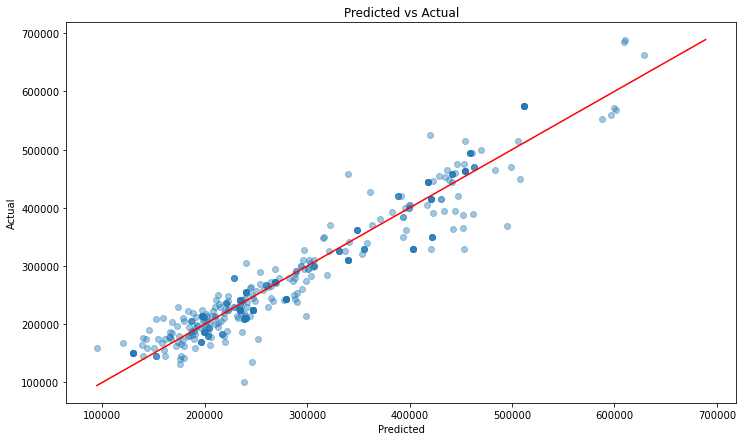

In [110]:
plot_prediction(y_test, y_pred)

In [69]:
svm_model = build_model(X_train, y_train, "svm")

svm_model.score(X_test, y_test)

0.695206327716771

In [111]:
y_pred = svm_model.predict(X_test)

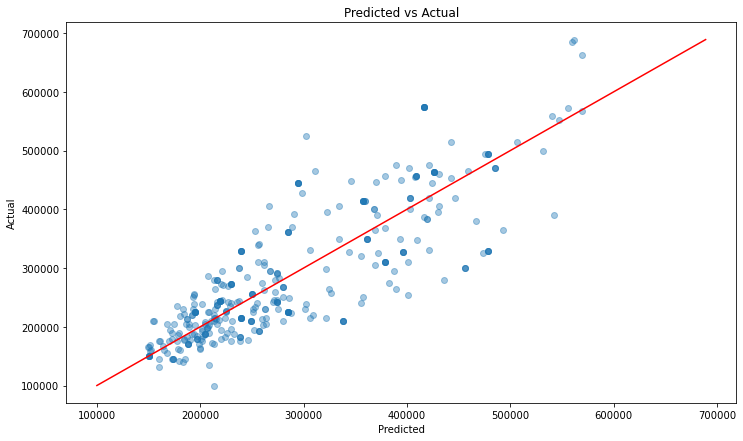

In [112]:
plot_prediction(y_test, y_pred)

In [115]:
randomforest_model = build_model(X_train, y_train, "randomforest")

randomforest_model.score(X_test, y_test)

0.940872254478869

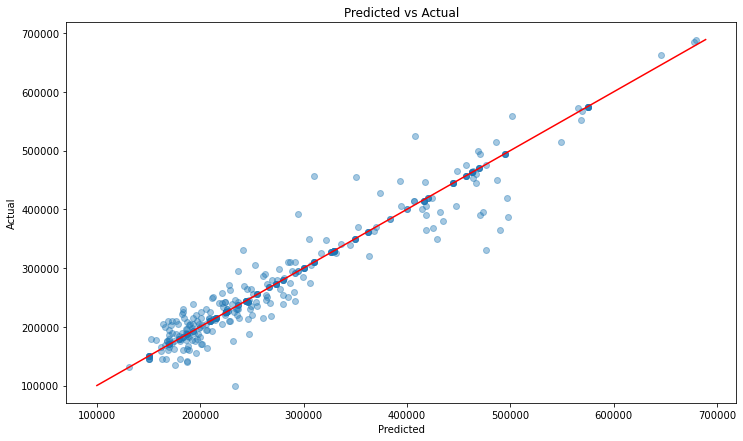

In [116]:
y_pred = randomforest_model.predict(X_test)
plot_prediction(y_test, y_pred)

In [73]:
spesificModels = df["Model"].unique()
spesificModels.sort()

In [74]:
selectedModel = widgets.Dropdown(
    options=spesificModels,
    description='Number:',
    disabled=False,
)
selectedModel

Dropdown(description='Number:', options=('1.0 GreenTec Ambition', '1.0 GreenTec Style', '1.0 TSI Elite', '1.0 …

In [75]:
spesificModelsDF = pd.DataFrame(columns=spesificModels, dtype=int)
spesificModelsDF.loc[0, selectedModel.value] = 1
spesificModelsDF.fillna(0, inplace=True)
spesificModelsDF

,1.0 GreenTec Ambition,1.0 GreenTec Style,1.0 TSI Elite,1.0 TSI Premium,1.0 TSI Premium Colour Concept,1.2 Ambiente,1.2 Ambiente Dynamic,1.2 Ambition,1.2 Classic,1.2 Comfort,...,1.6 TDI Ambiente,1.6 TDI Ambiente Dynamic,1.6 TDI Ambition,1.6 TDI Combi Scout,1.6 TDI Elegance,1.6 TDI Optimal,1.9 TDI Ambiente,1.9 TDI Comfort,1.9 TDI Elegance,1.9 TDI RS
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [76]:
year = widgets.BoundedIntText(
    value=2022,
    min=1950,
    max=2022,
    step=1,
    description='Year:',
    disabled=False
)
year

BoundedIntText(value=2022, description='Year:', max=2022, min=1950)

In [77]:
km = widgets.IntSlider(
    value=0,
    min=0,
    max=1000000,
    step=1000,
    description='KM:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)
km

IntSlider(value=0, continuous_update=False, description='KM:', max=1000000, step=1000)

In [117]:
print(linear_model.predict([[year.value, km.value, *spesificModelsDF.values[0]]]))

[372200.64311589]


/Users/berkkan/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
